In [1]:
import os
import random
from typing import Any, Dict, List, Set, Union

import warnings
from PIL import Image
from datasets import Dataset, load_dataset
from huggingface_hub import create_repo
from segment.components.base import Component
from segment.components.detect.DetectDino import DetectDino
from segment.components.segment.SegmentSam import SegmentSam
from segment.utils import get_coco_style_polygons, unload_box, unload_mask
from segment.visualizer import visualizer
from segment.format_results import ResultFormatter
from segment.components.data_manager import DataManager
from segment.components.training_manager import TrainingManager
from segment.components.component_manager import ComponentManager
from utilities.logger_config import get_logger
from tqdm.auto import tqdm

logger = get_logger()

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
class DotDict(dict):
    """Dot notation access to dictionary attributes"""

    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [3]:
class ImagenHeap:
    def __init__(self):
        self.data_manager = DataManager()
        self.component_manager = ComponentManager()
        self.training_manager = TrainingManager()
        self.result_formatter = ResultFormatter()
        self.batch_size = None
        self.dataset = None
        self.images = None
        self.processed_results = None
        self.formatted_results = None
        self.component_configs = {}

    def load_dataset(self, ds: Union[str, Dataset]) -> Dataset:
        self.dataset = self.data_manager.load(ds)
        self.images = self.dataset["image"]
        return self.dataset

    def add_args(self, component_name: str):
        """Get configuration object for a specific component."""
        if component_name not in self.component_configs:
            self.component_configs[component_name] = DotDict()
        return self.component_configs[component_name]

    def get_initial_data(self):
        return {
            "images": self.images,
        }

    def set_batch_size(self, batch_size: int = 8):
        self.component_manager.set_batch_size(batch_size)

    def format_results(self):
        if self.processed_results is not None:
            self.formatted_results = self.result_formatter.format_all_results(
                self.processed_results
            )

    def process_dataset(self) -> Dict[str, Any]:
        if self.component_manager.batch_size is None:
            self.set_batch_size()

        if self.dataset is None or self.images is None:
            raise ValueError("Dataset not loaded. Please load a dataset first.")

        initial_data = self.get_initial_data()

        self.processed_results = self.component_manager.process(
            initial_data, self.component_configs
        )
        self.format_results()

    def get_formatted_results(self) -> List[Dict[str, Any]]:
        if self.formatted_results is None:
            raise ValueError(
                "No formatted results available. Please process the dataset first."
            )
        return self.formatted_results

    def visualize(self, index: int = None):
        if index is None:
            index = random.randint(0, len(self.images) - 1)

        if self.images is None or self.formatted_results is None:
            raise ValueError(
                "Images or results not available. Please load and process the dataset first."
            )

        image = self.images[index]
        result = self.formatted_results[index]
        visualizer(image, result)

    def train_model(self, model_config: Dict[str, Any]):
        if self.dataset is None:
            raise ValueError("Dataset not loaded. Please load a dataset first.")
        self.training_manager.train_model(self.dataset, model_config)

    def push_to_hub(
        self, repo_id: str, token: str, commit_message: str = "md", private: bool = True
    ):
        if self.dataset is None:
            raise ValueError("Dataset not loaded. Please load a dataset first.")
        self.data_manager.push_to_hub(repo_id, token, commit_message, private)

    def set_pipeline(self, pipeline: List[str]):
        self.component_manager.set_pipeline(pipeline)

    def register_component(self, component: Component):
        self.component_manager.register_component(component)

In [4]:
image_dir = "datasets/fashion_people_detection/images/val"

ds = load_dataset("imagefolder", data_dir=image_dir, split="train")
ds = ds.shuffle()

Resolving data files:   0%|          | 0/95 [00:00<?, ?it/s]

In [5]:
# Usage example
imagen_heap = ImagenHeap()

# Register components
imagen_heap.register_component(DetectDino())
imagen_heap.register_component(SegmentSam())

# Set pipeline
imagen_heap.set_pipeline(["detect","segment"])

In [6]:
# Load dataset
imagen_heap.load_dataset(ds)

# Set component-specific configurations
text_prompt = [
    "hair",
    "face",
    "neck",
    "arm",
    "hand",
    "back",
    "leg",
    "foot",
    "outfit",
    "phone",
    "hat",
    "shoe",
]

imagen_heap.add_args("detect").text_prompt = text_prompt
imagen_heap.add_args("segment").return_tensors = True

In [7]:
imagen_heap.set_batch_size(10)

In [8]:
imagen_heap.component_manager.batch_size

10

In [9]:
# Process dataset and get formatted results
imagen_heap.process_dataset()

Overall Progress:   0%|          | 0/2 [00:00<?, ?it/s]

final text_encoder_type: bert-base-uncased
Model loading result: _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


Using Detect:   0%|          | 0/95 [00:00<?, ?it/s]

Using Segment:   0%|          | 0/95 [00:00<?, ?it/s]

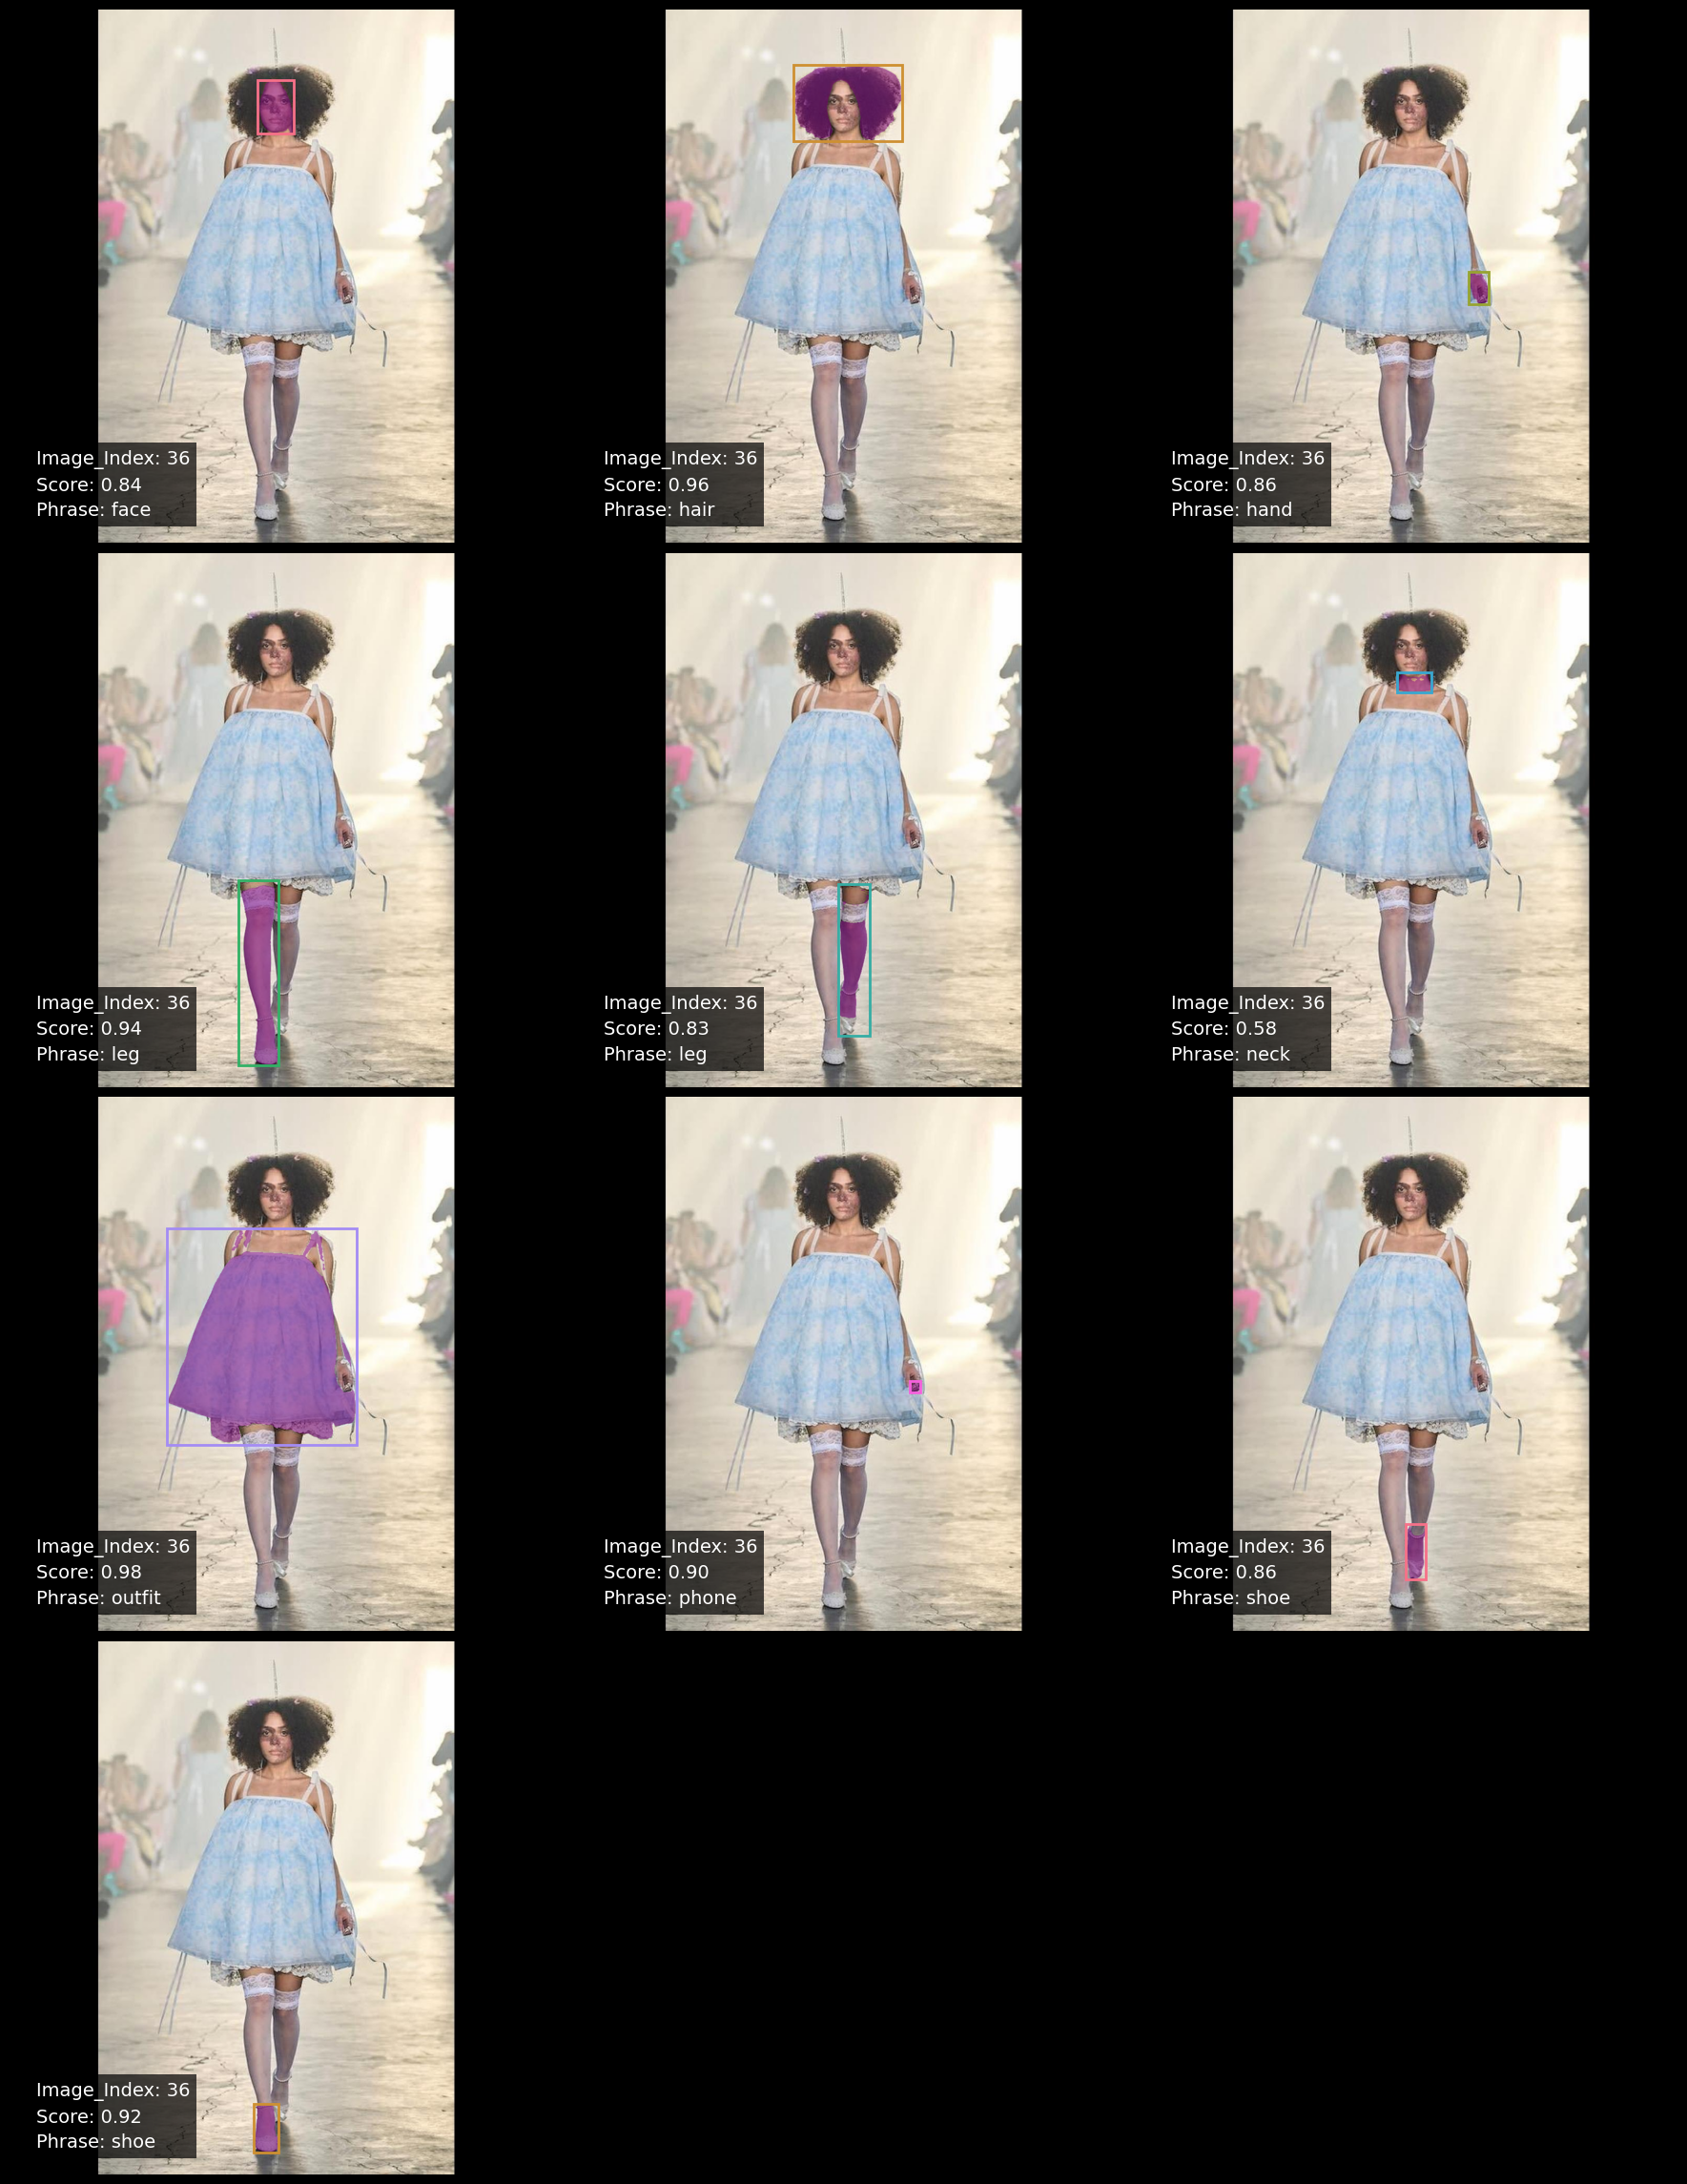

In [10]:
# Visualize a specific result
imagen_heap.visualize()